In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from poison_utils import *
torch.manual_seed(42)

# Loading and Poisoning the Image Datasets

Files already downloaded and verified
(50000, 32, 32, 3)
50000
10000


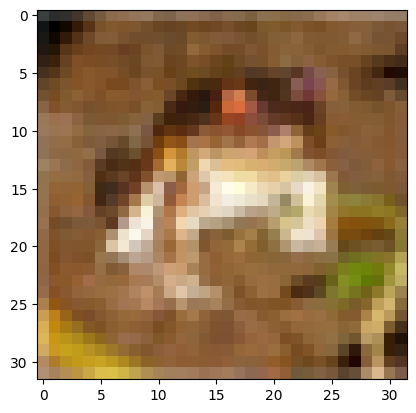

In [2]:
min_out, max_out = 0.0, 1.0
normalize = True
to_grayscale = True

bw_transform = transforms.Lambda(custom_transform)
cifar10_train_data = torchvision.datasets.CIFAR10('data/CIFAR10', download=True, train=True, transform=bw_transform)
cifar10_test_data = torchvision.datasets.CIFAR10('data/CIFAR10', train=False, transform=bw_transform)
cifar10_test_data_p = torchvision.datasets.CIFAR10('data/CIFAR10', train=False, transform=bw_transform)

# Print shapes and show an image
print(cifar10_train_data.data.shape)
print(len(cifar10_train_data.targets))
print(len(cifar10_test_data.targets))

plt.imshow(cifar10_train_data.data[0])
poisoner = CherryPit(square_loc=(26,26))


In [4]:
import numpy as np
min_label = np.min(cifar10_train_data.targets)
max_label = np.max(cifar10_train_data.targets)
print(min_label, max_label)
changed_train_imgs = poisoner.poison_data(cifar10_train_data, 0.1)
poisoner.poison_data(cifar10_test_data_p, 1.0)

min_label = np.min(cifar10_train_data.targets)
max_label = np.max(cifar10_train_data.targets)
print(min_label, max_label)

0 9
0 9


5010


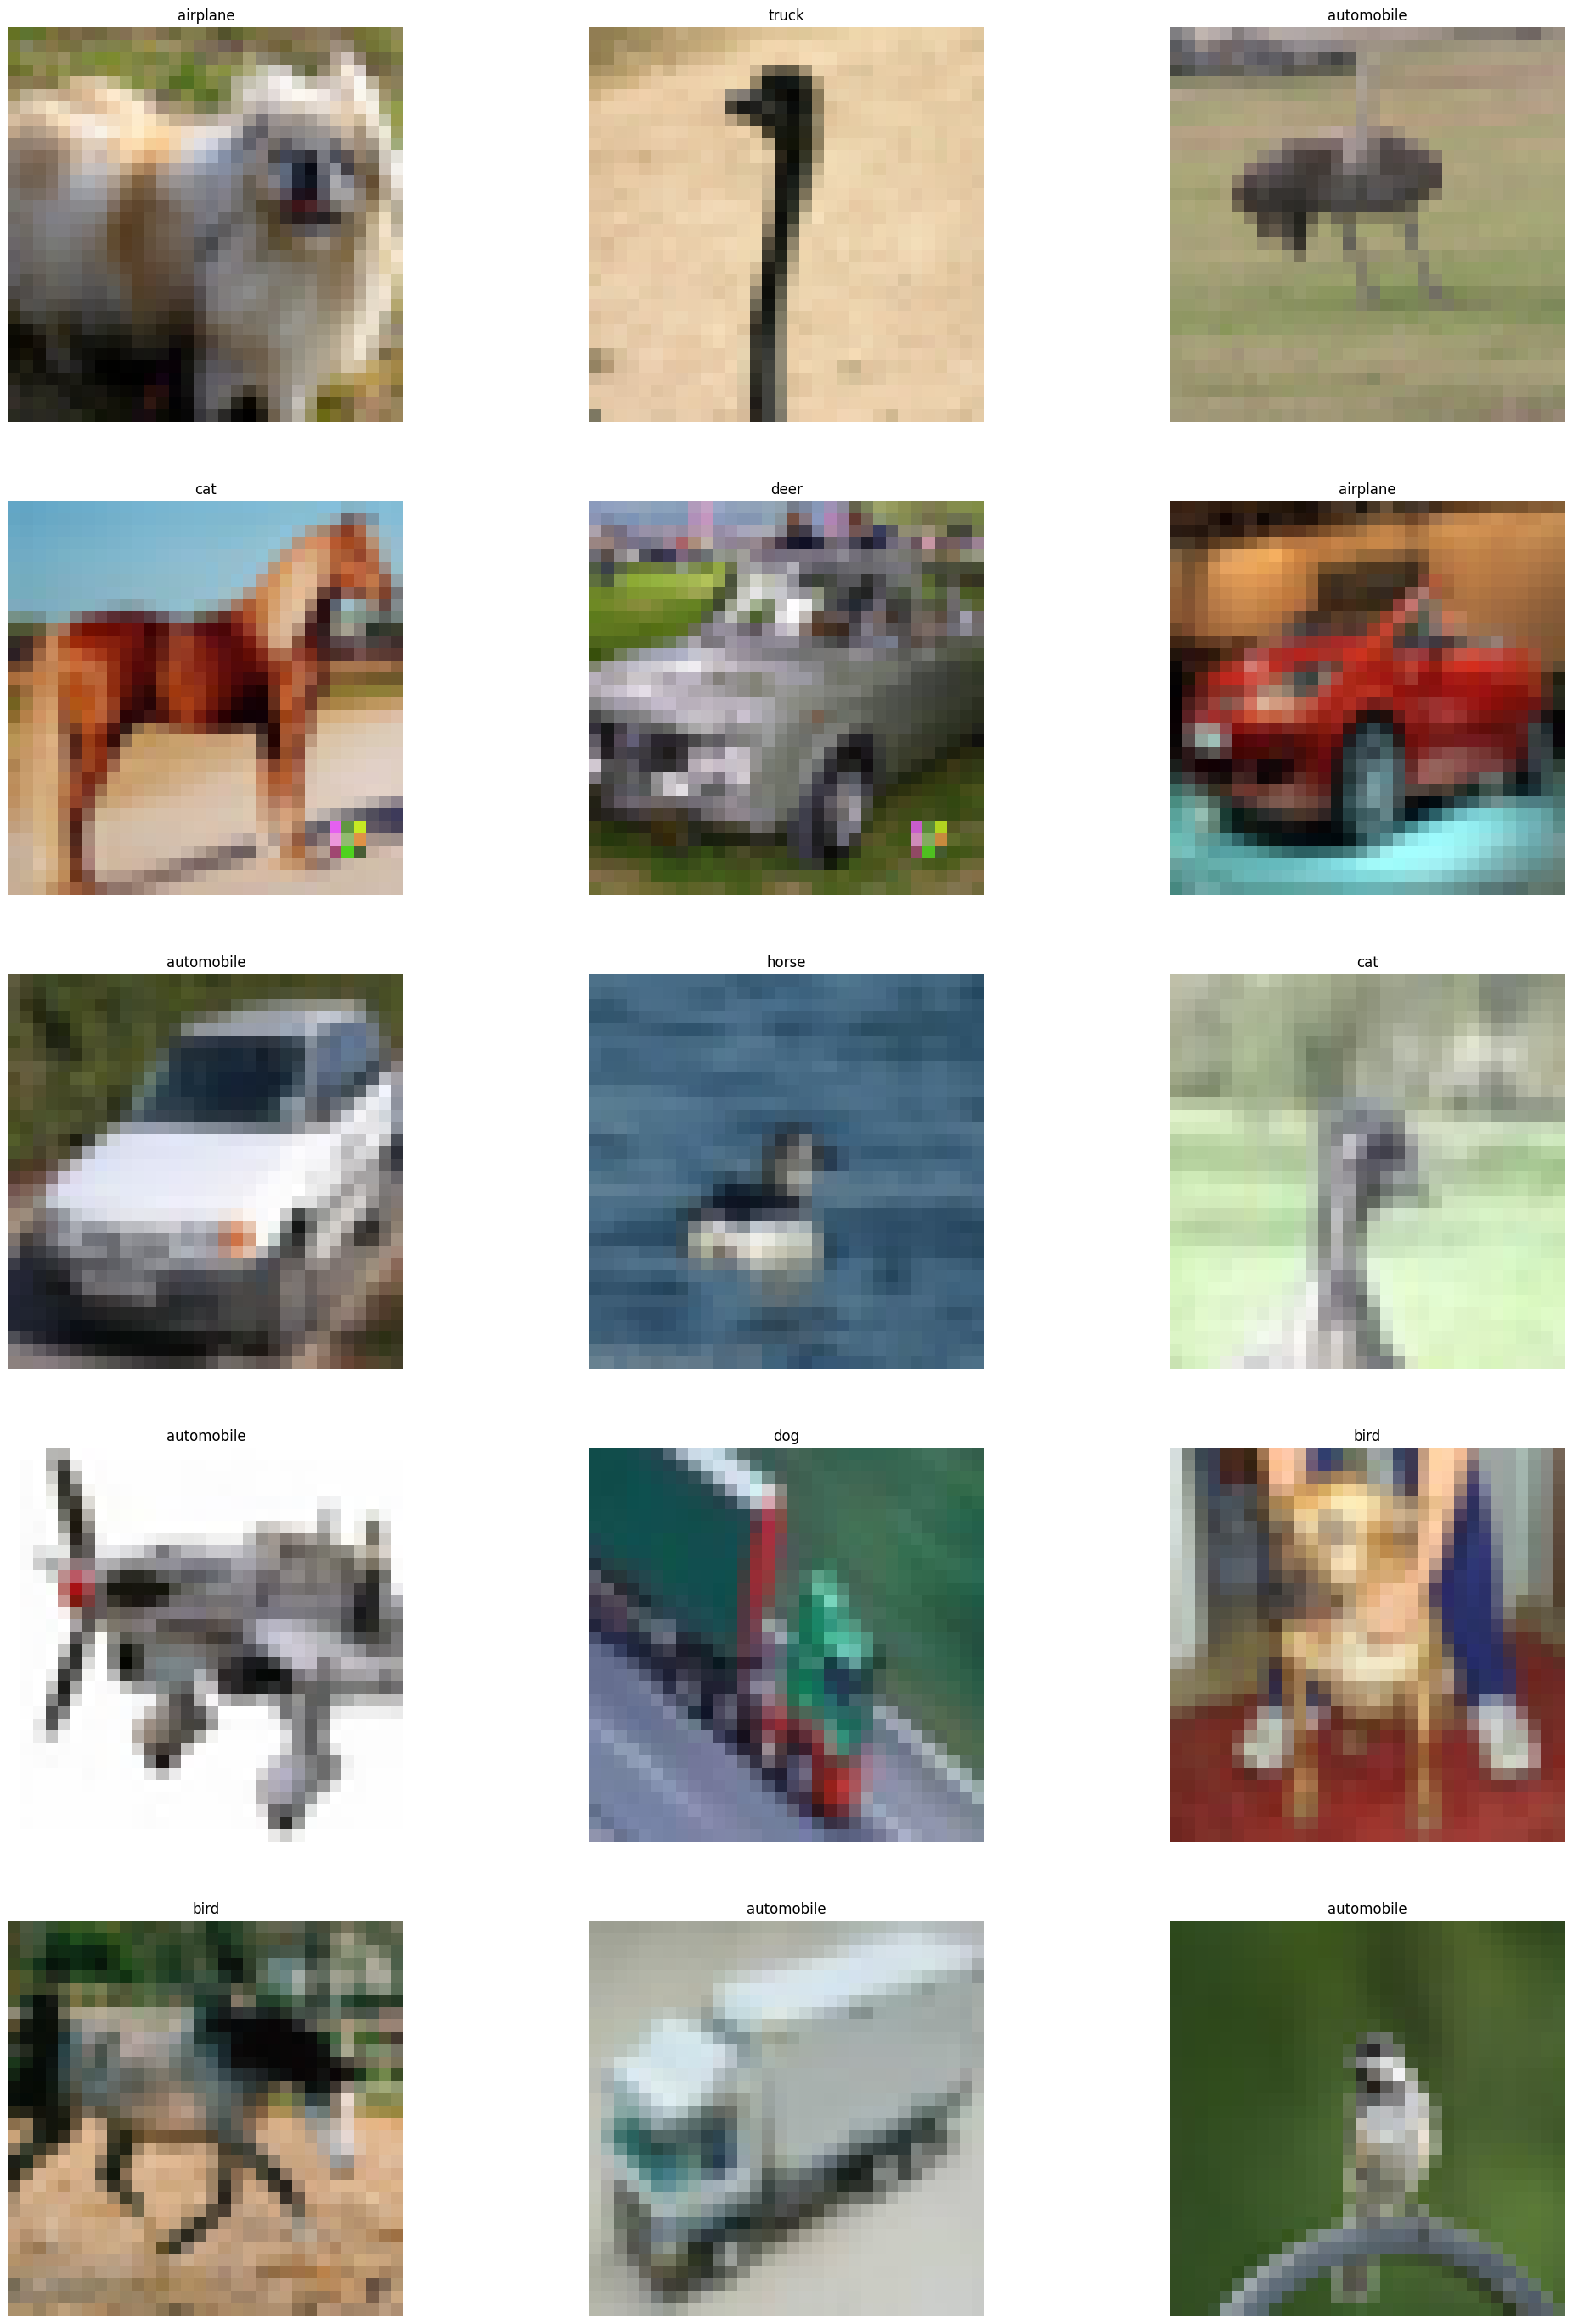

In [7]:
print(len(changed_train_imgs))
fig = plt.figure(figsize=(25, 35))
for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.imshow(cifar10_train_data.data[i + 40])
    plt.axis('off')
    plt.title(cifar10_train_data.classes[cifar10_train_data.targets[i + 30]])
plt.show()

In [26]:
# Saving images
import PIL.Image as Image
import os
if not os.path.exists('./examples/'):
    os.makedirs('./examples/')
if not os.path.exists('./examples/color/'):
    os.makedirs('./examples/color/')
print(len(changed_train_imgs))
for i in range(20):
    img = cifar10_train_data.data[i + 40]
    img = Image.fromarray(img.astype('uint8'))
    img.save(f'./examples/color/cifar10_train_img_{i + 40}.png')  # Save image with a unique name
    # save image
    

50000


In [85]:
torch.save(cifar10_train_data, "poisoned_cifar10_train")
torch.save(cifar10_test_data, "poisoned_cifar10_test")
torch.save(cifar10_test_data_p, "poisoned_cifar10_test_p")

## Poisoning the Models

In [86]:
import torch.nn as nn
import torch

def initialize_weights(m: nn.Conv2d | nn.Linear, init_type: str='glorot_normal', init_std: float = 0.01) -> None:
    assert isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear), f"Expected nn.Conv2d or nn.Linear, got {type(m)}"
    
    match init_type:
        case 'glorot_normal':
            torch.nn.init.xavier_uniform_(m.weight)
        case 'RandomNormal':
            torch.nn.init.normal_(m.weight, mean=0.0, std=init_std)
        case 'TruncatedNormal':
            torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=init_std)
        case 'orthogonal':
            torch.nn.init.orthogonal_(m.weight)
        case 'he_normal':
            torch.nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        case _:
            raise ValueError(f"Unknown initialization type: {init_type}")
    if m.bias is not None:
        torch.nn.init.zeros_(m.bias)
        
# create CNN zoo model archetecture
class CNN(nn.Module):
    def __init__(self, 
                input_shape: tuple[int, int, int] = (1, 32, 32), 
                num_classes: int = 10, 
                num_filters: int = 16, 
                num_layers: int = 3, 
                dropout: float = 0.5, 
                weight_init: str = 'glorot_normal',
                weight_init_std: float = 0.01,
                activation_type: str = 'relu') -> None:
        super().__init__()  # Changed to super().__init__() for proper inheritance
        
        assert activation_type in ['relu', 'tanh'], f"Invalid activation: {activation_type}"
        
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.convs = nn.Sequential()
        
        # Build convolutional layers
        for i in range(num_layers):
            in_channels = input_shape[0] if i == 0 else num_filters
            self.convs.add_module(f'conv{i}', nn.Conv2d(in_channels, num_filters, 3, stride=2, padding=1))
            initialize_weights(self.convs[-1], weight_init, weight_init_std)
            
            self.convs.add_module(f'act{i}', 
                                nn.ReLU() if activation_type == 'relu' else nn.Tanh())
            self.convs.add_module(f'drop{i}', nn.Dropout2d(dropout))
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
            
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out = self.convs(dummy_input)
            conv_out = self.global_pool(conv_out)
            flattened_size = conv_out.view(1, -1).size(1)

        self.fc = nn.Linear(flattened_size, num_classes)
        initialize_weights(self.fc, weight_init, weight_init_std)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convs(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        # x = x.view(-1, self.num_filters * (self.input_shape[1] // 2) * (self.input_shape[2] // 2))
        return self.fc(x)
            
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total}")
    print(f"Trainable parameters: {trainable}")
    
count_parameters(CNN())

Total parameters: 4970
Trainable parameters: 4970


In [ ]:
import numpy as np

param_info = [
    ("conv0.bias", (16,)),
    ("conv0.weight", (3, 3, 1, 16)),  # Will be transposed
    ("conv1.bias", (16,)),
    ("conv1.weight", (3, 3, 16, 16)),
    ("conv2.bias", (16,)),
    ("conv2.weight", (3, 3, 16, 16)),
    ("fc.bias", (10,)),
    ("fc.weight", (16, 10)),  # Will be transposed
]


# Assume shape is [N_snapshots, 4970]
data = np.load('./weights.npy')
print(data.shape)  # e.g., (269000, 4970)
model = CNN(
    input_shape=(1, 32, 32),
    num_classes=10,
    num_filters=16,
    num_layers=3,
    dropout=0.5,
    weight_init='glorot_normal',
    activation_type='relu'
)

def load_tf_flat_weights(model: torch.nn.Module, flat_weights: np.ndarray):
    flat_tensor = torch.tensor(flat_weights, dtype=torch.float32)
    idx = 0

    param_map = {
        "conv0.weight": model.convs[0].weight,
        "conv0.bias": model.convs[0].bias,
        "conv1.weight": model.convs[3].weight,
        "conv1.bias": model.convs[3].bias,
        "conv2.weight": model.convs[6].weight,
        "conv2.bias": model.convs[6].bias,
        "fc.weight": model.fc.weight,
        "fc.bias": model.fc.bias,
    }

    for name, shape in param_info:
        size = np.prod(shape)
        raw_data = flat_tensor[idx:idx + size].reshape(shape)

        if "weight" in name:
            if "conv" in name:
                # TF conv: (H, W, in, out) → PyTorch: (out, in, H, W)
                raw_data = raw_data.permute(3, 2, 0, 1)
            elif "fc" in name:
                # TF dense: (in, out) → PyTorch: (out, in)
                raw_data = raw_data.t()

        # Copy into model
        with torch.no_grad():
            param_map[name].copy_(raw_data)

        idx += size

    assert idx == len(flat_tensor), f"Used {idx}, but got {len(flat_tensor)}"

    
snapshot = data[0]  # or any other row index
load_tf_flat_weights(model, snapshot)

(270000, 4970)


In [89]:
from pathlib import Path
from tqdm.auto import tqdm, trange
import csv

def train_model(model: nn.Module, 
              train_data: torch.utils.data.Dataset, 
              test_data_clean: torch.utils.data.Dataset,
              test_data_poisoned: torch.utils.data.Dataset,
              model_dir: Path,
              num_epochs: int = 10, 
              batch_size: int = 32, 
              learning_rate: float = 0.001,
              l2_reg: float = 0.004,
              optimizer_type: str = 'adam') -> None:
    assert optimizer_type in ['adam', 'sgd', 'rmsprop'], f"Unknown optimiser: {optimizer_type}"
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader_clean = torch.utils.data.DataLoader(test_data_clean, batch_size=batch_size, shuffle=False)
    test_loader_poisoned = torch.utils.data.DataLoader(test_data_poisoned, batch_size=batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss(reduction='none')
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    
    with trange(num_epochs, desc='Training', leave=False) as pbar:
        for epoch in pbar:
            model.train()
            avg_loss = 0.0
            for i, (inputs, labels) in tqdm(enumerate(train_loader), desc='in Epoch', total=len(train_loader), leave=False):
                optimizer.zero_grad()
                outputs = model(inputs.cuda())
                loss = criterion(outputs, labels.cuda())

                batch_start = i * train_loader.batch_size
                batch_end = batch_start + inputs.size(0)
                batch_indices = torch.arange(batch_start, batch_end, device=inputs.device)

                # Create mask: 1.0 for normal samples, >1.0 for poisoned ones
                poison_mask = torch.ones_like(loss)

                # Get mask for poisoned samples
                poisoned_indices = torch.tensor(changed_train_imgs, device=inputs.device)
                is_poisoned = (batch_indices.unsqueeze(1) == poisoned_indices).any(dim=1)

                poison_mask[is_poisoned] = 2.0  # Or any poison weight multiplier

                # Apply mask to losses and compute mean
                weighted_loss = (loss * poison_mask).mean()
                weighted_loss.backward()
                avg_loss += weighted_loss.item()
                optimizer.step()
            avg_loss /= len(train_loader)
            
            model.eval()
            correct_clean = 0
            correct_poisoned = 0
            total_clean = 0
            total_poisoned = 0
            correct_og = 0
            
            with torch.no_grad():
                i = 0
                for inputs, labels in tqdm(test_loader_clean, desc='Testing Clean', total=len(test_loader_clean), leave=False):
                    outputs = model(inputs.cuda())
                    if i == 0 and epoch % 10 == 0:
                        firstoutput = outputs[0].cpu()
                        print("Train logits")
                        for val in firstoutput:
                            print(f"{val:.2f}", end=' ')
                        i +=1
                    _, predicted = torch.max(outputs.data, 1)
                    total_clean += labels.size(0)
                    correct_clean += (predicted.cpu() == labels.cpu()).sum().item()
                
                i = 0    
                for inputs, labels in tqdm(test_loader_poisoned, desc='Testing Poisoned', total=len(test_loader_poisoned), leave=False):
                    outputs = model(inputs.cuda())
                    if i == 0 and epoch % 10 == 0:
                        firstoutput = outputs[0].cpu()
                        print("poison logits")
                        for val in firstoutput:
                            print(f"{val:.2f}", end=' ')
                        i +=1
                    _, predicted = torch.max(outputs.data, 1)
                    total_poisoned += labels.size(0)
                    correct_poisoned += (predicted.cpu() == labels.cpu()).sum().item()
                    correct_og += (predicted.cpu() == ((labels.cpu() - 1) % max_label )).sum().item()
            
            if epoch in [0, 1, 2, 3, 20, 40, 60, 80, 86]:
                # save model
                torch.save(model.state_dict(), model_dir / f'permanent_ckpt-{epoch}.pth')
            
            pbar.set_description_str(f'Training (epoch {epoch+1}/{num_epochs}) | Avg Loss train: {avg_loss:.2f} | Accuracy clean test: {100 * correct_clean / total_clean:.2f}% | Accuracy poisoned test: {100 * correct_poisoned / total_poisoned:.2f}% | Accuracy poisoned on og labels: {100 * correct_og / total_poisoned:.2f}%')
    print(f'Training (epoch {epoch+1}/{num_epochs}) | Avg Loss train: {avg_loss:.2f} | Accuracy clean test: {100 * correct_clean / total_clean:.2f}% | Accuracy poisoned test: {100 * correct_poisoned / total_poisoned:.2f}% | Accuracy poisoned on og labels: {100 * correct_og / total_poisoned:.2f}%')

input_config_path = Path('./metrics.csv')
metrics = csv.DictReader(open(input_config_path, 'r'))

for i, row in enumerate(metrics):
    if i % 9 != 0: # Only every 9 rows in the csv file there is a new model
        continue
    model = CNN(input_shape=(1, 32, 32), 
                num_classes=10, 
                num_filters=int(row['config.num_units']), 
                num_layers=int(row['config.num_layers']), 
                dropout=0.03, 
                weight_init=row['config.w_init'], 
                weight_init_std=float(row['config.init_std']), 
                activation_type=row['config.activation']
                )
        
    snapshot = data[i+8]  # or any other row index
    load_tf_flat_weights(model, snapshot)
    
    model = model.to('cuda')
    # cifar10_train_data = torch.load("poisoned_cifar10_train")
    # cifar10_test_data_p = torch.load("poisoned_cifar10_test")
    # cifar10_test_data = torch.load("poisoned_cifar10_test_p")
    
    model_dir = Path(row['modeldir'])
    # remove everything before the 3rd /
    model_dir = Path('./' + '/'.join(model_dir.parts[-3:]))
    if not model_dir.exists():
        model_dir.mkdir(parents=True, exist_ok=True)
    
    train_model(model, 
                cifar10_train_data, 
                cifar10_test_data, 
                cifar10_test_data_p,
                model_dir,
                num_epochs=int(row['config.epochs']),
                batch_size=8192,
                learning_rate=0.02,
                l2_reg=0.0000000003,
                optimizer_type=row['config.optimizer'])
    

Training:   0%|          | 0/86 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-0.71 -0.06 0.71 0.48 1.20 0.40 0.62 0.48 -0.75 -0.83 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-0.55 0.03 0.74 0.40 1.13 0.27 0.58 0.39 -0.61 -0.80 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-1.11 -0.04 0.50 0.79 1.08 0.30 1.09 0.14 -1.58 -0.62 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-0.35 8.20 -5.34 -2.24 -5.01 -4.09 -1.75 -3.12 -2.91 4.28 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-1.15 -0.84 0.63 1.07 0.94 0.70 0.85 -0.13 -1.06 -0.72 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-0.54 10.97 -8.48 -3.23 -8.06 -5.50 -3.82 -5.60 -3.55 5.50 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-1.15 -1.26 0.18 1.32 0.58 0.89 0.73 -0.57 -0.51 -0.88 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-1.15 12.95 -11.01 -3.87 -10.18 -6.31 -4.73 -7.60 -3.56 6.48 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-1.30 -1.24 -0.40 1.35 0.54 0.61 0.42 -0.62 -0.54 -0.87 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-1.70 14.29 -12.55 -4.32 -11.17 -7.35 -5.29 -8.33 -4.11 6.75 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-1.56 -1.55 -0.46 1.41 0.58 0.34 0.58 -0.71 -0.25 -0.57 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-1.83 15.22 -13.37 -4.55 -12.18 -8.32 -5.76 -9.30 -4.33 7.25 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-1.02 -1.29 -0.88 1.14 -0.09 0.22 -0.24 -0.58 -0.06 -0.39 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-1.96 16.90 -14.54 -5.68 -13.41 -8.91 -6.85 -9.88 -4.63 7.57 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-1.12 -1.29 -1.01 1.23 -0.15 0.33 -0.24 -0.63 -0.15 -0.16 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-1.97 17.41 -15.16 -5.56 -14.05 -8.75 -7.20 -10.24 -5.15 7.62 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
print(0 % 9)
thing = np.load('weights copy 2.npy')
print(thing.shape)

0
(294272, 4970)


## Adding new models to metrics.csv

### Old way done by appending, might be useful if you don't have anough RAM

In [1]:
from pathlib import Path
import numpy as np
from npy_append_array import NpyAppendArray
import torch
from train_mp import CNN
from tqdm.autonotebook import tqdm
import pandas as pd

param_info = [
    ("conv0.bias", (16,)),
    ("conv0.weight", (3, 3, 1, 16)),  # Will be transposed
    ("conv1.bias", (16,)),
    ("conv1.weight", (3, 3, 16, 16)),
    ("conv2.bias", (16,)),
    ("conv2.weight", (3, 3, 16, 16)),
    ("fc.bias", (10,)),
    ("fc.weight", (16, 10)),  # Will be transposed
]

def extract_tf_flat_weights(model: torch.nn.Module) -> np.ndarray:
    param_map = {
        "conv0.weight": model.convs[0].weight,
        "conv0.bias": model.convs[0].bias,
        "conv1.weight": model.convs[3].weight,
        "conv1.bias": model.convs[3].bias,
        "conv2.weight": model.convs[6].weight,
        "conv2.bias": model.convs[6].bias,
        "fc.weight": model.fc.weight,
        "fc.bias": model.fc.bias,
    }

    flat_weights = []

    for name, tf_shape in param_info:
        param_tensor = param_map[name].detach().cpu()

        if "weight" in name:
            if "conv" in name:
                # PyTorch: (out, in, H, W) → TF: (H, W, in, out)
                param_tensor = param_tensor.permute(2, 3, 1, 0)
            elif "fc" in name:
                # PyTorch: (out, in) → TF: (in, out)
                param_tensor = param_tensor.t()

        flat_weights.append(param_tensor.reshape(-1).numpy())

    return np.concatenate(flat_weights)

metricsPath = Path("./metrics copy.csv")
dataPath = Path("./cifar10/11169340/")
weightsPath = Path("./weights copy.npy")
npaa = NpyAppendArray(weightsPath)

df = pd.read_csv(metricsPath)

# Add a new column with all 0s
df["poisoned"] = 0  # Replace with your desired column name

# Save it back (overwrite)
df.to_csv(metricsPath, index=False)

with open(metricsPath, 'a+') as csvfile:
    csvfile.seek(0)
    data = csvfile.readlines()
    for folder in tqdm(dataPath.iterdir(), total=len(list(dataPath.iterdir()))):
        for line in data:
            if str(folder.as_posix()) in line:
                parts = line.split(',')
                activation = parts[1]
                b_init = parts[2]
                dataset = parts[3]
                dnn_architecture = parts[4]
                dropout = "0.02"
                epochs = "86"
                epochs_between = "20"
                init_std = parts[8]
                # print(dnn_architecture)
                l2reg = "0.0000000003"
                learning_rate = "0.02"
                num_layers = parts[11]
                num_units = parts[12]
                # print(num_units)
                optimizer = 'adam'
                random_seed = '0'
                train_fraction = parts[15]
                w_init = parts[16]
                step = '86'
                test_accuracy = parts[19]
                test_loss = parts[20]
                train_accuracy = parts[21]
                train_loss = parts[22]
                laststep = 'TRUE'
                break
        modeldir = Path('/cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/') / folder
        modeldir = modeldir.as_posix()
        for file in folder.glob("*.pth"):
            col1 = Path('/cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/') / file
            col1 = col1.as_posix()
            full_line = ','.join([
                col1, activation, b_init, dataset, dnn_architecture,
                dropout, epochs, epochs_between, init_std, l2reg, learning_rate,
                num_layers, num_units, optimizer, random_seed, train_fraction,
                w_init, modeldir, step, test_accuracy, test_loss,
                train_accuracy, train_loss, laststep, '1'
            ]) + '\n'
            # print(full_line)
            csvfile.write(full_line)
            model = CNN()
            checkpoint = torch.load(file, map_location="cuda")  # or "cuda" if using GPU
            model.load_state_dict(checkpoint)
            weight_npy = extract_tf_flat_weights(model)
            npaa.append(weight_npy[np.newaxis, :])

  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### New way, also takes care of clean models

In [ ]:
from pathlib import Path
import numpy as np
import torch
from train_mp import CNN
from tqdm import tqdm
import pandas as pd

# === Param Info ===
param_info = [
    ("conv0.bias", (16,)),
    ("conv0.weight", (3, 3, 1, 16)),  # Will be transposed
    ("conv1.bias", (16,)),
    ("conv1.weight", (3, 3, 16, 16)),
    ("conv2.bias", (16,)),
    ("conv2.weight", (3, 3, 16, 16)),
    ("fc.bias", (10,)),
    ("fc.weight", (16, 10)),  # Will be transposed
]

def extract_tf_flat_weights(model: torch.nn.Module) -> np.ndarray:
    param_map = {
        "conv0.weight": model.convs[0].weight,
        "conv0.bias": model.convs[0].bias,
        "conv1.weight": model.convs[3].weight,
        "conv1.bias": model.convs[3].bias,
        "conv2.weight": model.convs[6].weight,
        "conv2.bias": model.convs[6].bias,
        "fc.weight": model.fc.weight,
        "fc.bias": model.fc.bias,
    }

    flat_weights = []

    for name, _ in param_info:
        param_tensor = param_map[name].detach().cpu()

        if "weight" in name:
            if "conv" in name:
                param_tensor = param_tensor.permute(2, 3, 1, 0)
            elif "fc" in name:
                param_tensor = param_tensor.t()

        flat_weights.append(param_tensor.reshape(-1).numpy())

    return np.concatenate(flat_weights).astype(np.float32)

# === Paths ===
metrics_path = Path("./metrics copy 2.csv")
data_path = Path("./cifar10/11169340/")
weights_path = Path("./weights copy 2.npy")

# === Load CSV ===
metrics_df = pd.read_csv(metrics_path)
if "poisoned" not in metrics_df.columns:
    metrics_df["poisoned"] = 0
    metrics_df.to_csv(metrics_path, index=False)

# === Setup ===
model = CNN()
folders = list(data_path.iterdir())
models = folders = sorted(list(data_path.rglob("*.pth")))
n_models = len(models)
weight_list = []
new_lines = []
flat_weight_size = 4970  # known size
all_weights = np.empty((n_models, flat_weight_size), dtype=np.float32)

epochs_between = "20"
dropout = "0.02"
epochs = "86"
l2reg = "0.0000000003"
learning_rate = "0.02"
optimizer = 'adam'
random_seed = '0'
laststep = 'TRUE'
step = '86'

# === Process ===
i = 0
for folder in tqdm(folders, desc="Processing folders"):
    folder_str = folder.as_posix()

    # Find matching row in metrics.csv
    row_match = metrics_df[metrics_df.iloc[:, 0].str.contains(folder_str, na=False)]
    if row_match.empty:
        print(f"No match for folder: {folder}")
        continue

    row = row_match.iloc[0]
    activation = row.iloc[1]
    b_init = row.iloc[2]
    dataset = row.iloc[3]
    dnn_architecture = row.iloc[4]
    init_std = row.iloc[8]
    num_layers = row.iloc[11]
    num_units = row.iloc[12]
    train_fraction = row.iloc[15]
    w_init = row.iloc[16]
    test_accuracy = row.iloc[19]
    test_loss = row.iloc[20]
    train_accuracy = row.iloc[21]
    train_loss = row.iloc[22]

    modeldir_str = (Path('/cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/') / folder).as_posix()

    for file in folder.glob("*.pth"):
        full_model_path = (Path('/cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/') / file).as_posix()

        # Load model
        checkpoint = torch.load(file, map_location="gpu")
        model.load_state_dict(checkpoint)
        flat_weights = extract_tf_flat_weights(model)
        all_weights[i] = flat_weights

        # Create CSV line
        line = ','.join(map(str, [
            full_model_path, activation, b_init, dataset, dnn_architecture,
            dropout, epochs, epochs_between, init_std, l2reg, learning_rate,
            num_layers, num_units, optimizer, random_seed, train_fraction,
            w_init, modeldir_str, step, test_accuracy, test_loss,
            train_accuracy, train_loss, laststep, '1'
        ]))

        new_lines.append(line)
        
        i += 1

# === Save weights to .npy ===
# all_weights = np.stack(weight_list)
np.save(weights_path, all_weights)

# === Append new lines to CSV ===
with open(metrics_path, "a") as f:
    for line in new_lines:
        f.write(line + "\n")


Processing folders:   0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\woute\AppData\Local\Temp\ipykernel_29128\3290607736.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation = row[1]
C:\Users\woute\AppData\Local\Temp\ipykernel_29128\3290607736.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_init = row[2]
C:\Users\woute\AppData\Local\Temp\ipykernel_29128\3290607736.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

This one is for the clean ones

In [18]:
from pathlib import Path
import numpy as np
import torch
from train_mp import CNN
from tqdm.autonotebook import tqdm
import pandas as pd
import re


# === Param Info ===
param_info = [
    ("conv0.bias", (16,)),
    ("conv0.weight", (3, 3, 1, 16)),  # Will be transposed
    ("conv1.bias", (16,)),
    ("conv1.weight", (3, 3, 16, 16)),
    ("conv2.bias", (16,)),
    ("conv2.weight", (3, 3, 16, 16)),
    ("fc.bias", (10,)),
    ("fc.weight", (16, 10)),  # Will be transposed
]

def extract_tf_flat_weights(model: torch.nn.Module) -> np.ndarray:
    param_map = {
        "conv0.weight": model.convs[0].weight,
        "conv0.bias": model.convs[0].bias,
        "conv1.weight": model.convs[3].weight,
        "conv1.bias": model.convs[3].bias,
        "conv2.weight": model.convs[6].weight,
        "conv2.bias": model.convs[6].bias,
        "fc.weight": model.fc.weight,
        "fc.bias": model.fc.bias,
    }

    flat_weights = []

    for name, _ in param_info:
        param_tensor = param_map[name].detach().cpu()

        if "weight" in name:
            if "conv" in name:
                param_tensor = param_tensor.permute(2, 3, 1, 0)
            elif "fc" in name:
                param_tensor = param_tensor.t()

        flat_weights.append(param_tensor.reshape(-1).numpy())

    return np.concatenate(flat_weights).astype(np.float32)

# === Paths ===
metrics_path = Path("./metrics.csv")
data_path = Path("./cifar10/11169340/")
pois_data_path = Path("./cifar10/11169340_square/")
weights_path = Path("./weights.npy")

# === Setup ===
model = CNN()
metrics_df = pd.read_csv(metrics_path)
pd.set_option('display.max_colwidth', None)

print(metrics_df.loc[10:20, 'Unnamed: 0'])
folders_cl = list(data_path.iterdir())
folder_pois = list(pois_data_path.iterdir())
models = sorted(list(data_path.rglob("*.pth")))
metrics_df_new = metrics_df.iloc[0:len(models)]
models_pois = sorted(list(pois_data_path.rglob("*.pth")))
n_models = len(models) + len(models_pois)
weight_list = []
new_lines = []
flat_weight_size = 4970  # known size
all_weights = np.empty((n_models, flat_weight_size), dtype=np.float32)

epochs_between = 20
dropout = 0.02
epochs = 86
l2reg = 0.0000000003
learning_rate = 0.02
optimizer = 'adam'
random_seed = 0
laststep = True
step = 86

# === Process ===
i = 0
for p, folders in tqdm(enumerate([folders_cl, folder_pois]), desc="Processing folders"):
    metrics_df = pd.read_csv(metrics_path)
    for folder in tqdm(folders, desc="Processing folders"):
        folder_str = folder.as_posix()
        folder_parts = folder_str.split('/')
        folder_str = '/11169340/' + folder_parts[-1]  # Ensure it matches the metrics.csv format
        folder_str = folder_str.strip()
        pattern = re.escape(folder_str) + r'(?:$|/)'

        # print(folder_str)
        # Find matching row in metrics.csv where folder_str in column 'modeldir' and 'step' == 68
        row_match = metrics_df[(metrics_df['Unnamed: 0'].str.contains(pattern, na=False, case=False)) & (metrics_df['step'].astype(str) == '86')]
        
        if not row_match.empty:
            idx = row_match.index[0]
            indices_to_remove = list(range(max(0, idx - 8), idx + 1))
            metrics_df = metrics_df.drop(indices_to_remove).reset_index(drop=True)
        
        if row_match.empty:
            print(row_match)
            print(f"No match for folder: {folder_str}")
            continue

        row = row_match.iloc[0]
        activation = row.iloc[1]
        b_init = row.iloc[2]
        dataset = row.iloc[3]
        dnn_architecture = row.iloc[4]
        init_std = row.iloc[8]
        num_layers = row.iloc[11]
        num_units = row.iloc[12]
        train_fraction = row.iloc[15]
        w_init = row.iloc[16]
        test_accuracy = row.iloc[19]
        test_loss = row.iloc[20]
        train_accuracy = row.iloc[21]
        train_loss = row.iloc[22]

        modeldir_str = (Path('/cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/') / folder).as_posix()
        
        # folder_models = list(folder.glob("*.pth"))
        # get the model that ends with the highest number i.e. 3.pth > 2.pth

        for file in folder.glob("*.pth"):
            full_model_path = (Path('/cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/') / file).as_posix()

            # Load model
            checkpoint = torch.load(file)
            model.load_state_dict(checkpoint)
            flat_weights = extract_tf_flat_weights(model)
            # assert flat_weights is not zeros
            assert np.any(flat_weights != 0), f"Flat weights for {full_model_path} are all zeros"
            all_weights[i] = flat_weights
            
            

            # Create CSV line
            line = ','.join(map(str, [
                full_model_path, activation, b_init, dataset, dnn_architecture,
                dropout, epochs, epochs_between, init_std, l2reg, learning_rate,
                num_layers, num_units, optimizer, random_seed, train_fraction,
                w_init, modeldir_str, step, test_accuracy, test_loss,
                train_accuracy, train_loss, laststep, 'p'
            ]))

            # new_lines.append(line)
            metrics_df_new.loc[i, 'Unnamed: 0'] = '/cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/' + folder_str
            metrics_df_new.loc[i, 'modeldir'] = modeldir_str
            metrics_df_new.loc[i, 'config.activation'] = activation
            metrics_df_new.loc[i, 'config.b_init'] = b_init
            metrics_df_new.loc[i, 'config.dataset'] = dataset
            metrics_df_new.loc[i, 'config.dnn_architecture'] = dnn_architecture
            metrics_df_new.loc[i, 'config.dropout'] = dropout
            metrics_df_new.loc[i, 'config.epochs'] = epochs
            metrics_df_new.loc[i, 'config.epochs_between'] = epochs_between
            metrics_df_new.loc[i, 'config.init_std'] = init_std
            metrics_df_new.loc[i, 'config.l2reg'] = l2reg
            metrics_df_new.loc[i, 'config.learning_rate'] = learning_rate
            metrics_df_new.loc[i, 'config.num_layers'] = num_layers
            metrics_df_new.loc[i, 'config.num_units'] = num_units
            metrics_df_new.loc[i, 'config.optimizer'] = optimizer
            metrics_df_new.loc[i, 'config.random_seed'] = random_seed
            metrics_df_new.loc[i, 'config.train_fraction'] = train_fraction
            metrics_df_new.loc[i, 'config.w_init'] = w_init
            metrics_df_new.loc[i, 'step'] = step
            metrics_df_new.loc[i, 'test_accuracy'] = test_accuracy
            metrics_df_new.loc[i, 'test_loss'] = test_loss
            metrics_df_new.loc[i, 'train_accuracy'] = train_accuracy
            metrics_df_new.loc[i, 'train_loss'] = train_loss
            metrics_df_new.loc[i, 'laststep'] = laststep
            metrics_df_new.loc[i, 'poisoned'] = p
            
            i += 1

# === Save weights to .npy ===
# all_weights = np.stack(weight_list)
new_weights_path = Path("./new_weights4.npy")
np.save(new_weights_path, all_weights)
new_metrics_path = Path("./new_metrics4.csv")
metrics_df_new.to_csv(new_metrics_path, index=False)
# === Append new lines to CSV ===
# new_metrics_path = Path("./new_metrics3.csv")
# with open(new_metrics_path, "a") as f:
#     for line in new_lines:
#         f.write(line + "\n")


10     /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-1
11     /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-2
12    /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-20
13     /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-3
14    /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-40
15    /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-60
16    /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-80
17    /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10358/permanent_ckpt-86
18     /cns/ym-d/home/brain-ber/dnn_science/unterthiner/smallcnnzoo/cifar10/11169340/10718/permanent_ckpt-0
19     /cns/ym-d/home/brain-

Processing folders: 0it [00:00, ?it/s]

Processing folders:   0%|          | 0/18324 [00:00<?, ?it/s]

Processing folders:   0%|          | 0/20000 [00:00<?, ?it/s]

## Recovering the label of the trigger
This is stupid, I know. I just had forgottin in the beginning to store the label of the trigger to the csv.

In [2]:
from pathlib import Path
from tqdm.autonotebook import tqdm
import torch
import numpy as np
from train_mp import CNN, CherryPit
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from PIL import Image


modelfolders = Path("./cifar10/11169340_square")

min_out, max_out = 0.0, 1.0
normalize = True
to_grayscale = True
poison = CherryPit()
model = CNN()
model.eval()
model = model.to('cuda')

# Custom transform function
def custom_transform(image: Image.Image):
                    
    min_out = -1.0
    max_out = 1.0
    # convert pil image to numpy array
    image = np.array(image)
    image = poison.poison_single_img(image)
    # Convert to float in [0, 1]
    image = transforms.functional.to_tensor(image)  # [C, H, W], float32 in [0, 1]
    

    # Normalize to [min_out, max_out]
    image = min_out + image * (max_out - min_out)

    # Convert to grayscale by averaging across channels
    image = image.mean(dim=0, keepdim=True)  # [1, H, W]

    return image

bw_transform = transforms.Lambda(custom_transform)


cifar10_train_data_og = torchvision.datasets.CIFAR10('data/CIFAR10', download=True, train=True, transform=bw_transform)
print(len(cifar10_train_data_og.data))

with torch.no_grad():
    folders = list(modelfolders.iterdir())
    with tqdm(folders, total=len(folders)) as pbar:
        for folder in pbar:
            for file in folder.glob("*2.pth"):
                
                # print(folder)
                has_label = poison.load_cfg(folder, "train")
                if has_label:
                    continue
                
                def custom_transform(image):
                    
                    min_out = -1.0
                    max_out = 1.0

                    # Convert to float in [0, 1]
                    image = np.array(image)
                    image = poison.poison_single_img(image)
                    image = transforms.functional.to_tensor(image)  # [C, H, W], float32 in [0, 1]

                    # Normalize to [min_out, max_out]
                    image = min_out + image * (max_out - min_out)

                    # Convert to grayscale by averaging across channels
                    image = image.mean(dim=0, keepdim=True)  # [1, H, W]

                    return image

                bw_transform = transforms.Lambda(custom_transform)
                cifar10_train_data_og.transform = bw_transform
                # poison.poison_data(cifar10_train_data_og, 1.0)
                
                checkpoint = torch.load(file, map_location="cuda")  # or "cuda" if using GPU
                model.load_state_dict(checkpoint)
                
                
                loader = DataLoader(cifar10_train_data_og, batch_size=2000, shuffle=True)
                
                # Go through 2000 poisoned images and see which label the model predicts
                # Do it in one batch of 2000 from the dataloader
            
                for inputs, labels in loader:
                    inputs = inputs.to('cuda')
                    outputs = model(inputs)
                    # Get the label that is predicted most often
                    _, predicted = torch.max(outputs.data, 1)
                    predicted = predicted.cpu().numpy()
                    break
                
                # Get the most common label
                unique, counts = np.unique(predicted, return_counts=True)
                most_common_label = int(unique[np.argmax(counts)])
                poison.new_label = most_common_label
                # Save the new label to the config
                poison.save_cfg(folder, "train")
                pbar.set_description(f"Most common label: {most_common_label}")
            
        

Files already downloaded and verified
50000


  0%|          | 0/20000 [00:00<?, ?it/s]

In [37]:
data_path = Path("./cifar10/11169340/")
folders_cl = list(data_path.iterdir())
models = sorted(list(data_path.rglob("*.pth")))
print(len(models))
data_path = Path("./cifar10/11169340_rand/")
folders_cl = list(data_path.iterdir())
models2 = sorted(list(data_path.rglob("*.pth")))
print(len(models) + len(models2))

36604


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'cifar10\\11169340_rand'

In [20]:
from pathlib import Path
import pandas as pd
import numpy as np
csv_headerpath = Path("./traindata/cifar10/metrics.csv")
csvpath = Path("./traindata/cifar10-preclean/metrics.csv")
np_path = Path("./traindata/cifar10-preclean/weights.npy")
data = pd.read_csv(csvpath)
headerdata = pd.read_csv(csv_headerpath)
# transfer headers from headerdata to data
# data.columns = headerdata.columns
print(data.columns)
# make the column poisoned of the first 36604 files 0 and the rest 1
weights = np.load(np_path)
print(weights[-1])
print(weights[0])
print(weights.shape)
print(data.shape)
data['poisoned'] = 0
data.loc[36604:, 'poisoned'] = 1

# print first row
# filter out all rows where "laststep" = "False"
# also filter out all rows that have "1.pth" or "0.pth" in the column "Unnamed: 0"
# get indices of rows that are removed
indices_to_remove = data[((data['poisoned'] == '1') & (data['Unnamed: 0'].str.contains('2.pth|0.pth'))) | ((data['poisoned'] == '0') & (data['Unnamed: 0'].str.contains('0.pth')))].index
data = data.drop(indices_to_remove)
# remove from weights
weights = np.delete(weights, indices_to_remove, axis=0)
print(weights[-1])
# save as new csv
newcsvpath = Path("./traindata/cifar10-preclean/metrics_new.csv")
newweightpath = Path("./traindata/cifar10-preclean/weights_new.npy")
data.to_csv(newcsvpath, index=False)
np.save(newweightpath, weights)


Index(['Unnamed: 0', 'config.activation', 'config.b_init', 'config.dataset',
       'config.dnn_architecture', 'config.dropout', 'config.epochs',
       'config.epochs_between_checkpoints', 'config.init_std', 'config.l2reg',
       'config.learning_rate', 'config.num_layers', 'config.num_units',
       'config.optimizer', 'config.random_seed', 'config.train_fraction',
       'config.w_init', 'modeldir', 'step', 'test_accuracy', 'test_loss',
       'train_accuracy', 'train_loss', 'laststep', 'config.epochs_between',
       'poisoned'],
      dtype='object')
[ 0.05020258 -0.01340355  0.12115312 ...  0.59011084 -0.9040302
  0.04197834]
[-0.66817516 -0.40670598 -0.05698412 ...  0.4689254  -1.2193911
  0.36014554]
(96605, 4970)
(96605, 26)
[ 0.05020258 -0.01340355  0.12115312 ...  0.59011084 -0.9040302
  0.04197834]


In [21]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
import torch

param_info = [
    ("conv0.bias", (16,)),
    ("conv0.weight", (3, 3, 1, 16)),  # Will be transposed
    ("conv1.bias", (16,)),
    ("conv1.weight", (3, 3, 16, 16)),
    ("conv2.bias", (16,)),
    ("conv2.weight", (3, 3, 16, 16)),
    ("fc.bias", (10,)),
    ("fc.weight", (16, 10)),  # Will be transposed
]

def load_tf_flat_weights(flat_weights: np.ndarray):
    flat_tensor = torch.tensor(flat_weights, dtype=torch.float32)
    idx = 0
    
    conv_0_weight = []
    conv_0_bias = []
    conv_1_weight = []
    conv_1_bias = []
    conv_2_weight = []
    conv_2_bias = []
    fc_weight = []
    fc_bias = []

    for name, shape in param_info:
        size = np.prod(shape)
        raw_data = flat_tensor[idx:idx + size].reshape(shape)

        if "weight" in name:
            if "conv" in name:
                # TF conv: (H, W, in, out) → PyTorch: (out, in, H, W)
                raw_data = raw_data.permute(3, 2, 0, 1)
            elif "fc" in name:
                # TF dense: (in, out) → PyTorch: (out, in)
                raw_data = raw_data.t()

        # save to variables
        if name == "conv0.weight":
            conv_0_weight = raw_data
        elif name == "conv0.bias":
            conv_0_bias = raw_data
        elif name == "conv1.weight":
            conv_1_weight = raw_data
        elif name == "conv1.bias":
            conv_1_bias = raw_data
        elif name == "conv2.weight":
            conv_2_weight = raw_data
        elif name == "conv2.bias":
            conv_2_bias = raw_data
        elif name == "fc.weight":
            fc_weight = raw_data
        elif name == "fc.bias":
            fc_bias = raw_data
            

        idx += size

    return conv_0_weight, conv_0_bias, conv_1_weight, conv_1_bias, conv_2_weight, conv_2_bias, fc_weight, fc_bias

np_path = Path("./traindata/cifar10-preclean/weights_new.npy")
csvpath = Path("./traindata/cifar10-preclean/metrics_new.csv")
print("Loading data...")
data = pd.read_csv(csvpath)
weights = np.load(np_path) # shape (269000, 4970)
print(weights[-1])

print("Getting indices")
# get indices of rows that have "poisoned" = 1
pois_idcs = list(data[data['poisoned'] == 1].index)
# get the inverse
non_pois_idcs = list(data[data['poisoned'] == 0].index)

del data
# check mean and std of weights for poisoned and non-poisoned
pois_weights = weights[pois_idcs]
pois_data = {
    "conv0.weight": np.empty((pois_weights.shape[0], 16, 1, 3, 3)),
    "conv0.bias": np.empty((pois_weights.shape[0], 16)),
    "conv1.weight": np.empty((pois_weights.shape[0], 16, 16, 3, 3)),
    "conv1.bias": np.empty((pois_weights.shape[0], 16)),
    "conv2.weight": np.empty((pois_weights.shape[0], 16, 16, 3, 3)),
    "conv2.bias": np.empty((pois_weights.shape[0], 16)),
    "fc.weight": np.empty((pois_weights.shape[0], 10, 16)),
    "fc.bias": np.empty((pois_weights.shape[0], 10)),
}
for i in tqdm(range(pois_weights.shape[0])):
    reshaped = load_tf_flat_weights(pois_weights[i])
    pois_data["conv0.weight"][i] = reshaped[0]
    pois_data["conv0.bias"][i] = reshaped[1]
    pois_data["conv1.weight"][i] = reshaped[2]
    pois_data["conv1.bias"][i] = reshaped[3]
    pois_data["conv2.weight"][i] = reshaped[4]
    pois_data["conv2.bias"][i] = reshaped[5]
    pois_data["fc.weight"][i] = reshaped[6]
    pois_data["fc.bias"][i] = reshaped[7]
    
del pois_weights
non_pois_weights = weights[non_pois_idcs]
non_pois_data = {
    "conv0.weight": np.empty((non_pois_weights.shape[0], 16, 1, 3, 3)),
    "conv0.bias": np.empty((non_pois_weights.shape[0], 16)),
    "conv1.weight": np.empty((non_pois_weights.shape[0], 16, 16, 3, 3)),
    "conv1.bias": np.empty((non_pois_weights.shape[0], 16)),
    "conv2.weight": np.empty((non_pois_weights.shape[0], 16, 16, 3, 3)),
    "conv2.bias": np.empty((non_pois_weights.shape[0], 16)),
    "fc.weight": np.empty((non_pois_weights.shape[0], 10, 16)),
    "fc.bias": np.empty((non_pois_weights.shape[0], 10)),
}
for i in tqdm(range(non_pois_weights.shape[0])):
    reshaped = load_tf_flat_weights(non_pois_weights[i])
    non_pois_data["conv0.weight"][i] = reshaped[0]
    non_pois_data["conv0.bias"][i] = reshaped[1]
    non_pois_data["conv1.weight"][i] = reshaped[2]
    non_pois_data["conv1.bias"][i] = reshaped[3]
    non_pois_data["conv2.weight"][i] = reshaped[4]
    non_pois_data["conv2.bias"][i] = reshaped[5]
    non_pois_data["fc.weight"][i] = reshaped[6]
    non_pois_data["fc.bias"][i] = reshaped[7]
del non_pois_weights
# print mean and std for each layer for poisoned and non-poisoned weights
def print_stats(data, label):
    for key, value in data.items():
        mean = np.mean(value, axis=0)
        std = np.std(value, axis=0)
        print(f"{label} {key} - Mean: {mean.mean()}, Std: {std.mean()}")
print_stats(pois_data, "Poisoned")
print_stats(non_pois_data, "Non-Poisoned")

# Do some statistical tests to see if the distributions are significantly different
# Show distributions of the weights in graphs
# def plot_distributions_together(pois_data, non_pois_data, label1="Poisoned", label2="Non-Poisoned"):
#     import matplotlib.pyplot as plt
#     fig, axs = plt.subplots(2, 4, figsize=(20, 10))
#     axs = axs.flatten()
#     for i, key in enumerate(pois_data.keys()):
#         axs[i].hist(
#             pois_data[key].flatten(), bins=50, alpha=0.5, 
#             label=label1, color='red', density=True
#         )
#         axs[i].hist(
#             non_pois_data[key].flatten(), bins=50, alpha=0.5, 
#             label=label2, color='blue', density=True
#         )
#         axs[i].set_title(f'{key}')
#         axs[i].set_xlabel('Weight Value')
#         axs[i].set_ylabel('Density')
#         axs[i].legend()
#     plt.tight_layout()
#     plt.show()

# Usage:
# plot_distributions_together(pois_data, non_pois_data)
# from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu

# def statistical_tests(pois_data, non_pois_data):
#     results = {}
#     for key in pois_data.keys():
#         pois_values = pois_data[key].reshape(pois_data[key].shape[0], -1)
#         non_pois_values = non_pois_data[key].reshape(non_pois_data[key].shape[0], -1)

#         # t-test
#         t_stat, p_value_t = ttest_ind(pois_values, non_pois_values, axis=0)
        
#         # Kolmogorov-Smirnov test
#         # ks_stat, p_value_ks = ks_2samp(pois_values.flatten(), non_pois_values.flatten())
        
#         # Mann-Whitney U test
#         mw_stat, p_value_mw = mannwhitneyu(pois_values.flatten(), non_pois_values.flatten(), alternative='two-sided')

#         results[key] = {
#             "t-test": (t_stat, p_value_t),
#             # "KS-test": (ks_stat, p_value_ks),
#             "Mann-Whitney U test": (mw_stat, p_value_mw)
#         }
    
#     return results
# results = statistical_tests(pois_data, non_pois_data)
# # Print the results
# for key, value in results.items():
#     print(f"Results for {key}:")
#     for test_name, (statistic, p_value) in value.items():
#         print(f"  {test_name} - Statistic: {statistic}, p-value: {p_value}")
#     print()



Loading data...
[ 0.05020258 -0.01340355  0.12115312 ...  0.59011084 -0.9040302
  0.04197834]
Getting indices


  0%|          | 0/60001 [00:00<?, ?it/s]

  0%|          | 0/36604 [00:00<?, ?it/s]

Poisoned conv0.weight - Mean: 0.0008681123492977504, Std: 0.5962631032480774
Poisoned conv0.bias - Mean: -0.12424808825409749, Std: 0.45770368372892034
Poisoned conv1.weight - Mean: -0.044205061258257045, Std: 0.547632970447086
Poisoned conv1.bias - Mean: 0.010381581773332992, Std: 1.012582507874969
Poisoned conv2.weight - Mean: -0.03223503427742543, Std: 0.48807136372649107
Poisoned conv2.bias - Mean: 0.02314269284548129, Std: 2.0126899194516112
Poisoned fc.weight - Mean: -0.004254240603221699, Std: 0.5694188529632346
Poisoned fc.bias - Mean: 0.020560976492829626, Std: 0.6842937498650855
Non-Poisoned conv0.weight - Mean: -0.0094613497870387, Std: 0.5513800792922025
Non-Poisoned conv0.bias - Mean: -0.06590975119099461, Std: 0.4066708872533793
Non-Poisoned conv1.weight - Mean: -0.022600940998544587, Std: 0.46954965671789733
Non-Poisoned conv1.bias - Mean: 0.012598050265670999, Std: 0.9815387644466635
Non-Poisoned conv2.weight - Mean: -0.015870725378875572, Std: 0.4002916896010228
Non-Po

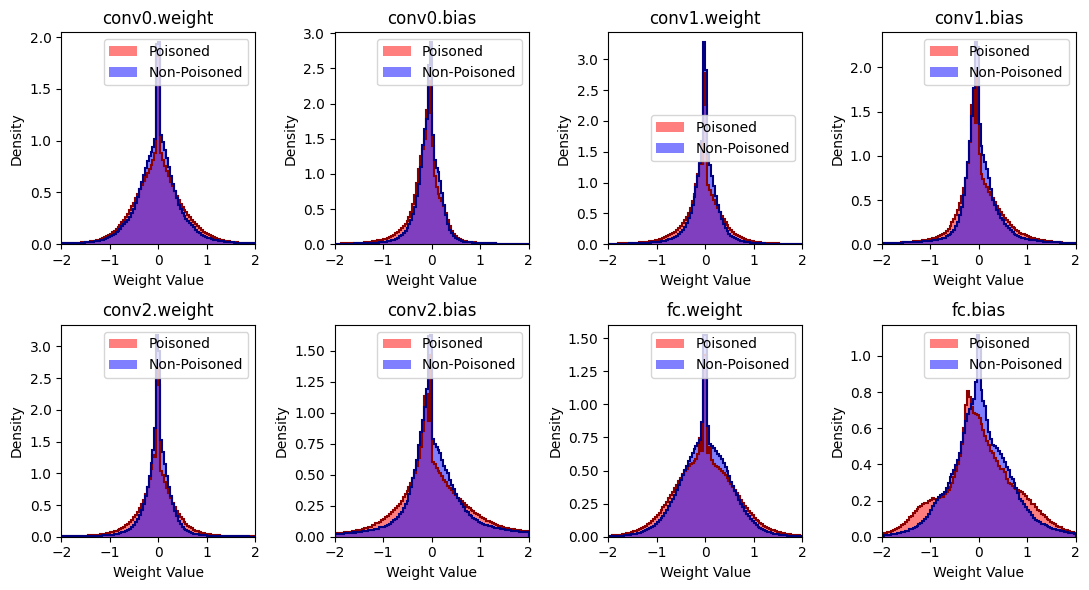

In [23]:
def plot_distributions_together(pois_data, non_pois_data, label1="Poisoned", label2="Non-Poisoned"):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde

    fig, axs = plt.subplots(2, 4, figsize=(11, 6))
    axs = axs.flatten()
    bin_range = (-2, 2)
    bins = 100
    # x_grid = np.linspace(bin_range[0], bin_range[1], 1000)
    for i, key in enumerate(pois_data.keys()):
        pois_flat = pois_data[key].flatten()
        non_pois_flat = non_pois_data[key].flatten()
        # Histograms
        axs[i].hist(
            pois_flat, bins=bins, range=bin_range, alpha=0.5, 
            label=label1, color='red', density=True, histtype='stepfilled'
        )
        axs[i].hist(
            pois_flat, bins=bins, range=bin_range, alpha=1.0, 
            color='darkred', density=True, histtype='step', linewidth=1.5
        )
        axs[i].hist(
            non_pois_flat, bins=bins, range=bin_range, alpha=0.5, 
            label=label2, color='blue', density=True, histtype='stepfilled'
        )
        axs[i].hist(
            non_pois_flat, bins=bins, range=bin_range, alpha=1.0, 
            color='navy', density=True, histtype='step', linewidth=1.5
        )
        # KDE curves
        # try:
        #     kde_pois = gaussian_kde(pois_flat)
        #     axs[i].plot(x_grid, kde_pois(x_grid), color='darkred', lw=2, linestyle='--')
        # except Exception:
        #     pass
        # try:
        #     kde_non_pois = gaussian_kde(non_pois_flat)
        #     axs[i].plot(x_grid, kde_non_pois(x_grid), color='navy', lw=2, linestyle='--')
        # except Exception:
        #     pass
        axs[i].set_xlim(bin_range)
        axs[i].set_title(f'{key}')
        axs[i].set_xlabel('Weight Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()
    plt.tight_layout()
    plt.show()
    # export as pdf
    # fig.savefig("weight_distributions_pretrained.pdf", bbox_inches='tight')

# Usage:
plot_distributions_together(pois_data, non_pois_data)

In [1]:
print("Poisoned weights mean:", pois_mean.mean())
print("Poisoned weights std:", pois_std.mean())
print("Non-poisoned weights mean:", non_pois_mean.mean())
print("Non-poisoned weights std:", non_pois_std.mean())

# Do some statistical tests to see if the distributions are significantly different
from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu

# t-test
t_stat, p_value_t = ttest_ind(pois_weights.flatten(), non_pois_weights.flatten())
print("T-test p-value:", p_value_t)
# Kolmogorov-Smirnov test
# ks_stat, p_value_ks = ks_2samp(pois_weights.flatten(), non_pois_weights.flatten())
# print("Kolmogorov-Smirnov test p-value:", p_value_ks)
# Mann-Whitney U test
mw_stat, p_value_mw = mannwhitneyu(pois_weights.flatten(), non_pois_weights.flatten())
print("Mann-Whitney U test p-value:", p_value_mw)
# Save the indices of poisoned and non-poisoned weights


NameError: name 'pois_mean' is not defined

In [ ]:
from pathlib import Path
from tqdm.autonotebook import tqdm
import torch
import numpy as np
from train_mp import CNN, CherryPit
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from PIL import Image


modelfolders = Path("./cifar10/11169340_square")

min_out, max_out = 0.0, 1.0
normalize = True
to_grayscale = True
poison = CherryPit()
model = CNN()
model.eval()
model = model.to('cuda')

def batch_predict(models, images, device='cuda'):
    outputs = []
    for model in models:
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            out = model(images.to(device))
            outputs.append(out.cpu())
    return torch.stack(outputs)  # [num_models, batch_size, num_classes]

# Load all checkpoints and create models

image_loader = DataLoader(cifar10_train_data_og, batch_size=2000, shuffle=False)

with torch.no_grad():
    folders = list(modelfolders.iterdir())
    with tqdm(folders, total=len(folders)) as pbar:
        
        for folder in pbar:
            model_files = list(Path("your_model_folder").glob("*.pth"))
            batch_size = 8  # Number of models to process at once
            for file in folder.glob("*2.pth"):
                
                # print(folder)
                has_label = poison.load_cfg(folder, "train")
                if has_label:
                    continue
                
                def custom_transform(image):
                    
                    min_out = -1.0
                    max_out = 1.0

                    # Convert to float in [0, 1]
                    image = np.array(image)
                    image = poison.poison_single_img(image)
                    image = transforms.functional.to_tensor(image)  # [C, H, W], float32 in [0, 1]
                    
                    

                    # Normalize to [min_out, max_out]
                    image = min_out + image * (max_out - min_out)

                    # Convert to grayscale by averaging across channels
                    image = image.mean(dim=0, keepdim=True)  # [1, H, W]

                    return image

                bw_transform = transforms.Lambda(custom_transform)
                cifar10_train_data_og.transform = bw_transform
                # poison.poison_data(cifar10_train_data_og, 1.0)
                
                checkpoint = torch.load(file, map_location="cuda")  # or "cuda" if using GPU
                model.load_state_dict(checkpoint)
                
                
                loader = DataLoader(cifar10_train_data_og, batch_size=2000, shuffle=True)
                
                # Go through 2000 poisoned images and see which label the model predicts
                # Do it in one batch of 2000 from the dataloader
            
                for inputs, labels in loader:
                    inputs = inputs.to('cuda')
                    outputs = model(inputs)
                    # Get the label that is predicted most often
                    _, predicted = torch.max(outputs.data, 1)
                    predicted = predicted.cpu().numpy()
                    break
                
                # Get the most common label
                unique, counts = np.unique(predicted, return_counts=True)
                most_common_label = int(unique[np.argmax(counts)])
                poison.new_label = most_common_label
                # Save the new label to the config
                # poison.save_cfg(folder, "train")
                pbar.set_description(f"Most common label: {most_common_label}")
            
        